In [42]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime

# Data Prep

## Shelter Data

In [43]:
shelter_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv']

dataframes = [pd.read_csv(file) for file in shelter_paths]

# Load each file and verify its contents
for file in shelter_paths:
    try:
        df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(df)} rows from {file}")
            dataframes.append(df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

# If all DataFrames are loaded correctly, concatenate them into one
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

combined_df = df

Loaded 50944 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv
Loaded 49478 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv
Loaded 48345 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv
The combined dataframe has 297534 rows.


In [44]:
combined_df = combined_df.dropna(subset=['CAPACITY_TYPE'])

# Separate data based on Capacity Type
bed_capacity_df = combined_df[combined_df['CAPACITY_TYPE'] == 'Bed Based Capacity'].copy()
room_capacity_df = combined_df[combined_df['CAPACITY_TYPE'] == 'Room Based Capacity'].copy()

# removing extra columns based on the capacity type
columns_to_drop = ['CAPACITY_TYPE', 'ORGANIZATION_NAME', 'SHELTER_GROUP', 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_NAME', 'ORGANIZATION_ID', 'SHELTER_ID', 'PROGRAM_ID']
bed_columns_to_drop = ['CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS', 'OCCUPANCY_RATE_ROOMS']
room_columns_to_drop = ['CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'OCCUPANCY_RATE_BEDS']

bed_capacity_df = bed_capacity_df.drop(columns_to_drop, axis=1)
bed_capacity_df = bed_capacity_df.drop(bed_columns_to_drop, axis=1)

room_capacity_df = room_capacity_df.drop(columns_to_drop, axis=1)
room_capacity_df = room_capacity_df.drop(room_columns_to_drop, axis=1)

# Convert OCCUPANCY_DATE to datetime
bed_capacity_df['OCCUPANCY_DATE'] = pd.to_datetime(bed_capacity_df['OCCUPANCY_DATE'],format='mixed')
room_capacity_df['OCCUPANCY_DATE'] = pd.to_datetime(room_capacity_df['OCCUPANCY_DATE'],format='mixed')

# Extract year, month, and day as separate features
bed_capacity_df['YEAR'] = bed_capacity_df['OCCUPANCY_DATE'].dt.year
bed_capacity_df['MONTH'] = bed_capacity_df['OCCUPANCY_DATE'].dt.month
bed_capacity_df['DAY'] = bed_capacity_df['OCCUPANCY_DATE'].dt.day

room_capacity_df['YEAR'] = room_capacity_df['OCCUPANCY_DATE'].dt.year
room_capacity_df['MONTH'] = room_capacity_df['OCCUPANCY_DATE'].dt.month
room_capacity_df['DAY'] = room_capacity_df['OCCUPANCY_DATE'].dt.day

# Label Encoding
label_encoder = LabelEncoder()

categorical_columns = ['SECTOR', 'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE', 'LOCATION_POSTAL_CODE', 'PROGRAM_AREA']

for column in categorical_columns:
    # Combine the data from both DataFrames (ensure consistency in encoding)
    combined_data = pd.concat([bed_capacity_df[column], room_capacity_df[column]], ignore_index=True)
    label_encoder.fit(combined_data)

    # Transform each dataframe separately
    bed_capacity_df[column] = label_encoder.transform(bed_capacity_df[column])
    room_capacity_df[column] = label_encoder.transform(room_capacity_df[column])

print(bed_capacity_df.head())
# print(room_capacity_df.head())

    _id OCCUPANCY_DATE  LOCATION_ID  LOCATION_POSTAL_CODE  SECTOR  \
5     6     2021-01-01       1051.0                    82       2   
10   11     2021-01-01       1029.0                   108       1   
11   12     2021-01-01       1102.0                   102       1   
21   22     2021-01-01       1009.0                    29       1   
25   26     2021-01-01       1065.0                     2       0   

    PROGRAM_MODEL  OVERNIGHT_SERVICE_TYPE  PROGRAM_AREA  SERVICE_USER_COUNT  \
5               0                       6             1                   6   
10              0                       6             1                  22   
11              0                       6             1                   8   
21              1                       6             1                  10   
25              0                       6             2                  11   

    CAPACITY_ACTUAL_BED  CAPACITY_FUNDING_BED  OCCUPIED_BEDS  UNOCCUPIED_BEDS  \
5                   8.0      

In [45]:
# Average Occupancy Rates
daily_avg_bed_occupancy = bed_capacity_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_BEDS'].mean().reset_index()
daily_avg_room_occupancy = room_capacity_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_ROOMS'].mean().reset_index()

In [46]:
# Single Shelter Example DF
bed_capacity_df_1051 = bed_capacity_df.loc[bed_capacity_df['LOCATION_ID'] == 1051.0]
# print(bed_capacity_df_1051.columns)
# print(bed_capacity_df_1051.head())

## Weather Data

In [47]:
weather_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2021_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2022_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2023_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2024_P1D.csv']

dataframes = [pd.read_csv(file) for file in weather_paths]

for file in weather_paths:
    try:
        weather_df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(weather_df)} rows from {file}")
            dataframes.append(weather_df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

if dataframes:
    combined_weather_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_weather_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

columns_to_drop = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag']
weather_df = combined_weather_df.drop(columns_to_drop, axis=1)

print(weather_df.head())

Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2021_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2022_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2023_P1D.csv
Loaded 366 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2024_P1D.csv
The combined dataframe has 2922 rows.
    Date/Time  Year  Month  Day  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0  2021-01-01  2021      1    1            2.5           -1.0             0.7   
1  2021-01-02  2021      1    2            2.2           -0.9             0.7   
2  2021-01-03  2021      1    3            2.1            0.2             1.1   
3  2021-01-04  2021      1    4            1.7           -0.1             0.8   
4  2021-01-05  2021      1    5            1.6            0.6             1.1   

   

# Prophet Code

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

In [48]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

## Combined Dataset

Here, I am testing how the model works at predicting the *overall* average shelter demand across all shelters in the city.

In [49]:
print(daily_avg_bed_occupancy.head())
df_prophet = daily_avg_bed_occupancy.reset_index().rename(columns={'OCCUPANCY_DATE': 'ds', 'OCCUPANCY_RATE_BEDS': 'y'})

  OCCUPANCY_DATE  OCCUPANCY_RATE_BEDS
0     2021-01-01            93.077159
1     2021-01-02            93.174659
2     2021-01-03            92.600568
3     2021-01-04            92.620455
4     2021-01-05            92.356932


In [50]:
df_single = daily_avg_bed_occupancy.reset_index().rename(columns={'OCCUPANCY_DATE': 'ds', 'OCCUPANCY_RATE_BEDS': 'y'})

m_single = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m_single.fit(df_single)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/yndv4n3d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/ugzaqb3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65625', 'data', 'file=/tmp/tmpx3d3vfte/yndv4n3d.json', 'init=/tmp/tmpx3d3vfte/ugzaqb3m.json', 'output', 'file=/tmp/tmpx3d3vfte/prophet_model6gk8ouqo/prophet_model-20240425013809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


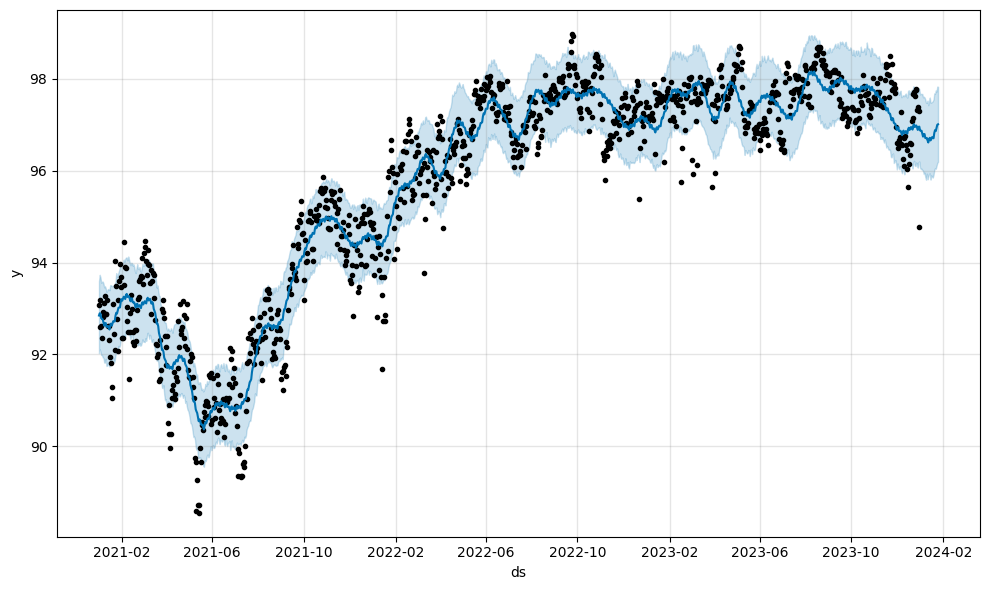

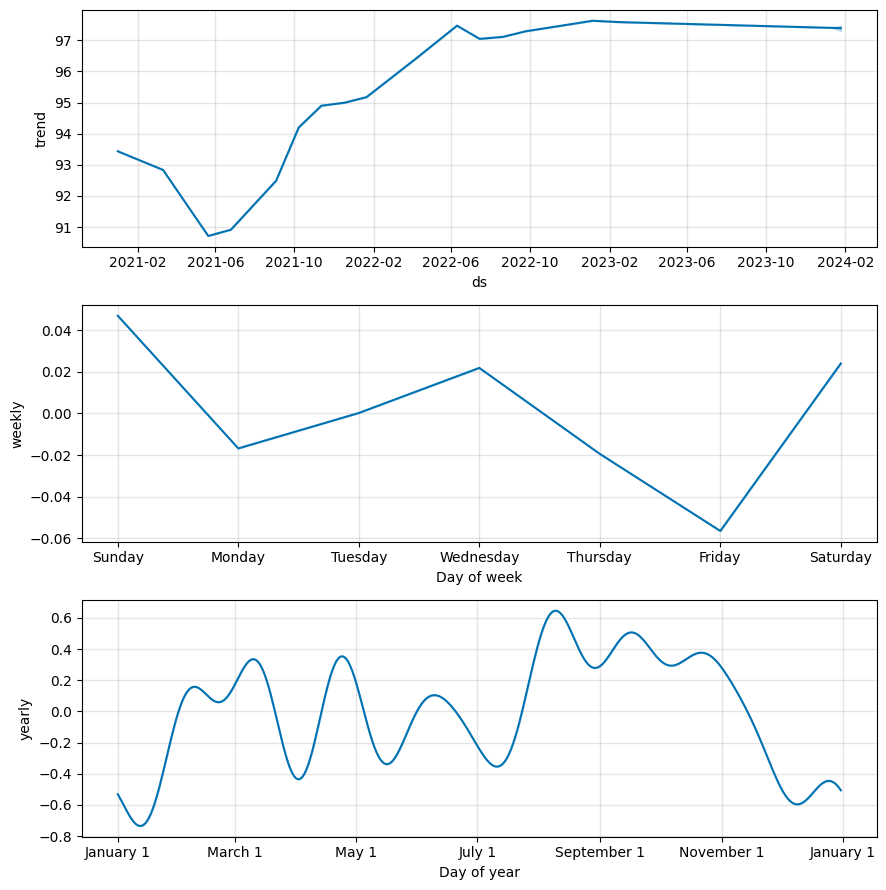

In [51]:
# forecasting
future = m_single.make_future_dataframe(periods=25) # For forecasting the next 12 months / 365 days
forecast = m_single.predict(future) # Make predictions

fig1 = m_single.plot(forecast)
fig2 = m_single.plot_components(forecast)

In [52]:
# Cross-validation
print("Cross-Validation Testing")
df_cv_single = cross_validation(m_single, initial='730 days', period='180 days', horizon='20 days')

# Performance metrics
df_p_single = performance_metrics(df_cv_single)
print(df_p_single.head())

INFO:prophet:Making 2 forecasts with cutoffs between 2023-06-14 00:00:00 and 2023-12-11 00:00:00


Cross-Validation Testing


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/nbggawpt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/07buafh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2993', 'data', 'file=/tmp/tmpx3d3vfte/nbggawpt.json', 'init=/tmp/tmpx3d3vfte/07buafh1.json', 'output', 'file=/tmp/tmpx3d3vfte/prophet_modeli70a6l9j/prophet_model-20240425013813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/5cdb_1oj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/kckow1fs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  2 days  0.199914  0.447117  0.427614  0.004401  0.004481  0.004403   
1  3 days  0.321743  0.567224  0.565451  0.005822  0.006009  0.005824   
2  4 days  0.450984  0.671554  0.645516  0.006669  0.006048  0.006660   
3  5 days  0.985556  0.992752  0.928168  0.009620  0.009346  0.009591   
4  6 days  1.015867  1.007902  0.948886  0.009832  0.009562  0.009803   

   coverage  
0      1.00  
1      1.00  
2      0.75  
3      0.25  
4      0.25  


## Individual Shelter Testing
For this section, I have chosen a single shelter as an example (LOCATION_ID = 1051.0)

In [55]:
def forecast_shelter_occupancy(combined_df, shelter_id):
    """
    Forecast the occupancy for a specific shelter using the Prophet model.

    Parameters:
    combined_df (DataFrame): The dataframe containing occupancy data for all shelters.
    shelter_id (float): The specific shelter ID for which to perform the forecast.

    Returns:
    DataFrame: A dataframe containing the performance metrics of the forecast.
    """
    # Filter data for the specific shelter
    specific_shelter_df = combined_df[combined_df['PROGRAM_ID'] == shelter_id]
    specific_shelter_df['OCCUPANCY_DATE'] = pd.to_datetime(specific_shelter_df['OCCUPANCY_DATE'], format='mixed')

    # Prepare the data for Prophet
    df_shelter = specific_shelter_df.reset_index().rename(columns={'OCCUPANCY_DATE': 'ds', 'OCCUPANCY_RATE_BEDS': 'y'})

    # Initialize and fit the Prophet model
    m_shelter = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    m_shelter.fit(df_shelter)

    # Perform cross-validation
    print(f"Cross-Validation Testing for Shelter ID {shelter_id}")
    df_cv_shelter = cross_validation(m_shelter, initial='730 days', period='180 days', horizon='10 days')
    df_p_shelter = performance_metrics(df_cv_shelter)

    return df_p_shelter[['horizon', 'mae', 'rmse']]

In [57]:
# Example DataFrame combined_df initialization
# Make sure to load or define your combined_df DataFrame here that contains the occupancy data

# List of shelter IDs to forecast
# shelter_ids = [11794, 11831, 12252, 12254, 12274]
shelter_ids = [11794, 11831, 12252, 12254]

# DataFrame to store all performance metrics
all_performance_metrics = pd.DataFrame()

for shelter_id in shelter_ids:
    # Run the forecasting function for each shelter
    performance_metrics_df = forecast_shelter_occupancy(combined_df, shelter_id)

    # Store the results
    performance_metrics_df['shelter_id'] = shelter_id  # Tag each row with its shelter ID
    all_performance_metrics = pd.concat([all_performance_metrics, performance_metrics_df], ignore_index=True)

# Calculate overall performance metrics
overall_mae = all_performance_metrics['mae'].mean()
overall_rmse = sqrt(all_performance_metrics['rmse'].pow(2).mean())

print(f"Overall Mean Absolute Error (MAE): {overall_mae:.2f}")
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse:.2f}")

<ipython-input-55-53b8bf9857fe>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_shelter_df['OCCUPANCY_DATE'] = pd.to_datetime(specific_shelter_df['OCCUPANCY_DATE'], format='mixed')
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/vybfsed1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/hipx7q2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6065', 'data', 'file=/tmp/tmpx3d3vfte/vybfsed1.json', 'init=/tmp/tmpx3d3vfte/hipx7q2v.json', 'output', 'file=/tmp/tmpx3d3vfte/prophet_mode

Cross-Validation Testing for Shelter ID 11794


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/howkcptz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/47uxhbi3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66446', 'data', 'file=/tmp/tmpx3d3vfte/howkcptz.json', 'init=/tmp/tmpx3d3vfte/47uxhbi3.json', 'output', 'file=/tmp/tmpx3d3vfte/prophet_modelqgyu_4dy/prophet_model-20240425014034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/zdx373_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/0_vd84t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Cross-Validation Testing for Shelter ID 11831


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/uoxp0d0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/zqqlcq4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41091', 'data', 'file=/tmp/tmpx3d3vfte/uoxp0d0s.json', 'init=/tmp/tmpx3d3vfte/zqqlcq4i.json', 'output', 'file=/tmp/tmpx3d3vfte/prophet_model_7u78klo/prophet_model-20240425014037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/5o6r5mex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/vjl9lvgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Cross-Validation Testing for Shelter ID 12252


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/bzjqm6el.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/fy9a_0bf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=437', 'data', 'file=/tmp/tmpx3d3vfte/bzjqm6el.json', 'init=/tmp/tmpx3d3vfte/fy9a_0bf.json', 'output', 'file=/tmp/tmpx3d3vfte/prophet_model3h8qsg0t/prophet_model-20240425014040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/ntju4k16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/ia_4ziyl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Cross-Validation Testing for Shelter ID 12254


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/4dwm6jqw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/p1y6cq4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1450', 'data', 'file=/tmp/tmpx3d3vfte/4dwm6jqw.json', 'init=/tmp/tmpx3d3vfte/p1y6cq4e.json', 'output', 'file=/tmp/tmpx3d3vfte/prophet_model75ec6tug/prophet_model-20240425014045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/7a5wwqc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx3d3vfte/4bdlu_an.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Overall Mean Absolute Error (MAE): 2.88
Overall Root Mean Squared Error (RMSE): 3.77
